In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import corner

import vpfits

from scipy.signal import savgol_filter

In [2]:
import pymc as pymc

In [3]:
import h5py

In [4]:
data = h5py.File('data/spectrum_m12.5n128_H1215_gal28_b10_los0.h5', 'r')

In [5]:
data.keys()

[u'density', u'flux', u'noise', u'tau', u'temp', u'velocity', u'wavelength']

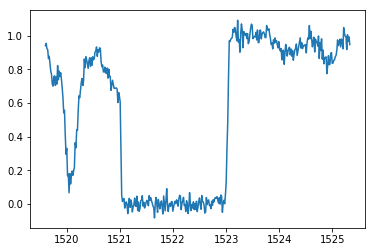

In [6]:
plt.plot(data['wavelength'][:], data['flux'][:])

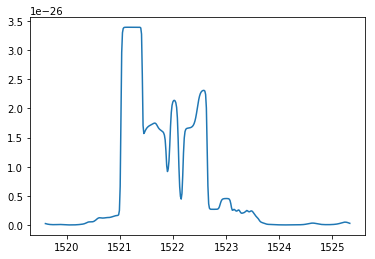

In [7]:
plt.plot(data['wavelength'][:], data['density'][:])

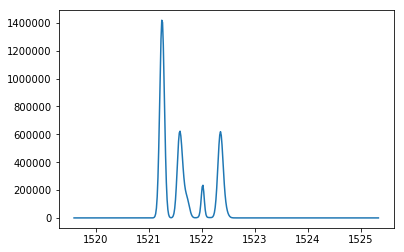

In [8]:
plt.plot(data['wavelength'][:], data['tau'][:])

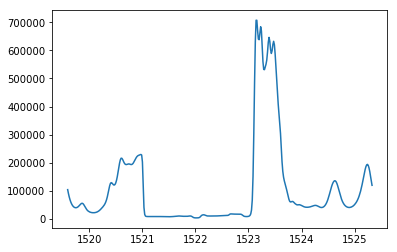

In [9]:
plt.plot(data['wavelength'][:], data['temp'][:])

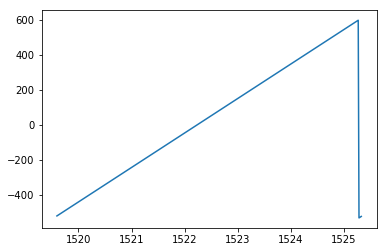

In [14]:
plt.plot(data['wavelength'][:], data['velocity'][:])

# data['velocity'][:]

#### Find regions

In [15]:
vpfit = vpfits.VPfit()

In [16]:
regions = vpfits.compute_detection_regions(data['wavelength'][:], data['flux'][:], 
                                           data['noise'][:], min_region_width=2)

Computing detection regions...
Found 3 detection regions.


In [17]:
window = 15

vpfit.find_local_minima(data['flux'][:], window=window)

array([ 34, 107, 148, 191, 214, 232, 315, 373])

In [19]:
region_arrays = []
region_pixels = []
local_minima = []

for i, region in enumerate(regions):
    
    start = np.where(data['wavelength'][:] == region[0])[0]
    end = np.where(data['wavelength'][:] == region[1])[0]
    
    region_pixels.append([start, end])
    region_arrays.append([data['wavelength'][:][start:end], data['flux'][:][start:end]])
    
    window=15

    local_minima.append(vpfit.find_local_minima(region_arrays[i][1], window=window))
    

TypeError: only integer scalar arrays can be converted to a scalar index

In [20]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')


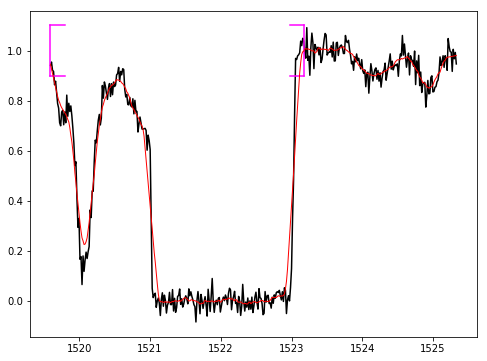

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(data['wavelength'][:], data['flux'][:], c='black')

for lmin, arr in zip(local_minima, region_arrays):
    ax.plot(arr[0], arr[1], color='blue')
    
    ax.vlines(arr[0][lmin], 1.2, -0.2, color='red', linestyle='dotted')

for (start, end) in region_pixels:
    plot_bracket(data['wavelength'][:][start], ax, 'left')
    plot_bracket(data['wavelength'][:][end], ax, 'right')
    
ax.plot(data['wavelength'][:], savgol_filter(data['flux'][:], window, 1), 'red', lw=1)


In [22]:
fits = []

for i in np.arange(len(region_arrays)):
    
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    vpfit_2 = vpfits.VPfit()
    local_minima = vpfit_2.find_local_minima(fluxes, window=window)
    
    r = False
    n = 1 # len(local_minima)
    
    print "n:", n
    
    # vpfit_2.initialise_model(wavelengths, fluxes, n, local_minima, voigt=True)
    vpfit_2.initialise_model(wavelengths, fluxes, n, voigt=True)
    vpfit_2.map_estimate()

    # while r < 0.95:
    while r == False:

        n += 1
        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        # vpfit_2.initialise_model(wavelengths, fluxes, n, local_minima, voigt=True)
        vpfit_2.initialise_model(wavelengths, fluxes, n, voigt=True)
        vpfit_2.map_estimate()
        
        print "Fit 1 AIC: ", vpfit_1.MAP.AIC, ", Fit 2 AIC: ", vpfit_2.MAP.AIC
        # print "AIC Ratio: ", vpfit_2.MAP.BIC / vpfit_1.MAP.BIC
        
        if vpfit_2.MAP.AIC > vpfit_1.MAP.AIC:
            r = True
            
        # r = vpfit_2.MAP.AIC / vpfit_1.MAP.AIC
    
    n -= 1
    print "n (final): ", n
    vpfit_1.mcmc_fit()
    
    fits.append(vpfit_1)
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    fig = vpfit_1.plot(wavelengths, fluxes, n=n, start_pix=start, end_pix=end)
    
    pylab.show()

In [23]:
n = 7
vpfit = vpfits.VPfit()
local_minima = vpfit.find_local_minima(fluxes, window=11)

# local_minima = local_minima[:2]

vpfit.initialise_model(wavelengths, fluxes, n, local_minima=local_minima, voigt=True)
# vpfit.initialise_model(wavelengths, fluxes, n, voigt=True)

# fig = vpfit.plot(wavelengths, fluxes, n=n, start_pix=start, end_pix=end)

NameError: name 'fluxes' is not defined

In [53]:
vpfit.MAP = pymc.MAP(vpfit.model)
vpfit.MAP.fit(method='fmin_powell', iterlim=1000, tol=.001)

print vpfit.MAP.AIC

-734.016107734


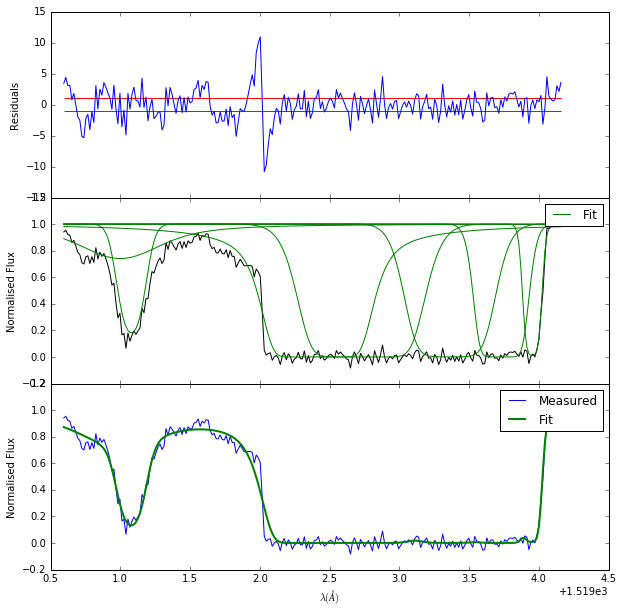

In [55]:
fig = vpfit.plot(wavelengths, fluxes, n=n, start_pix=start, end_pix=end)

In [56]:
vpfit.mcmc_fit()    

Using Metropolis step method for each parameter.
 [-----------------100%-----------------] 10000 of 10000 complete in 145.8 sec
Took: 0:02:25.813867  to finish.


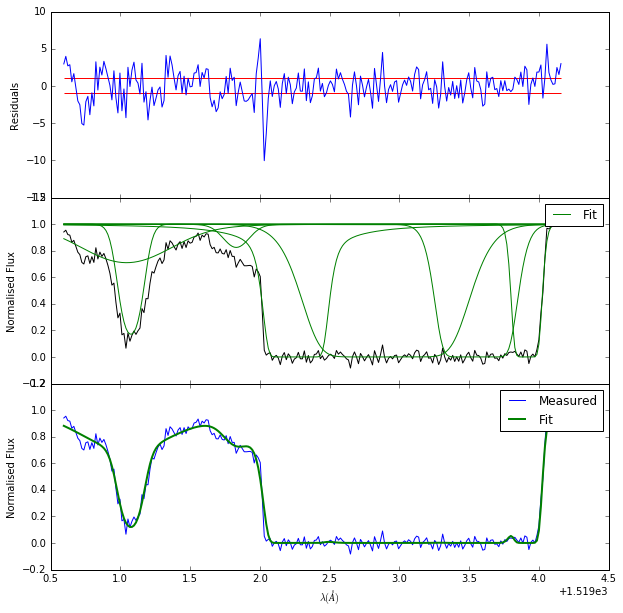

In [57]:
fig = vpfit.plot(wavelengths, fluxes, n=n, start_pix=start, end_pix=end)

91.9333756237
0.481012568809
3.08273281643
0.00203231356754
0.153901351122
1.59035510386
0.45002133441
3.11372405083
0.111467405969
0.654112105908
1.18384317702
1.23606864652
2.32767673873
0.0244749987642
0.197724954901
637.272607517
1.66268451741
1.90106086783
0.0107915624487
0.177662787812
802.736534626
2.30681118284
1.25693420241
0.0073015509491
0.582326128464
993.522577518
2.95552022862
0.608225156628
0.00398033682116
0.270508031456
984.573670215
3.31784137957
0.245904005672
0.0010503379253
0.108967982884


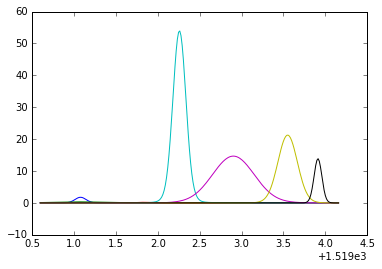

In [58]:
for i, p in enumerate(vpfit.estimated_profiles):
    
#     print vpfit.estimated_variables[i]['amplitude'].value
#     print np.abs(vpfit.estimated_variables[i]['centroid'].value - wavelengths[0])
#     print np.abs(vpfit.estimated_variables[i]['centroid'].value - wavelengths[-1])
#     print vpfit.estimated_variables[i]['L'].value
#     print vpfit.estimated_variables[i]['G'].value
    
    plt.plot(wavelengths, vpfit_1.VoigtFunction(wavelengths, 
                                                vpfit.estimated_variables[i]['centroid'].value,
                                                vpfit.estimated_variables[i]['amplitude'].value, 
                                                vpfit.estimated_variables[i]['L'].value,
                                                vpfit.estimated_variables[i]['G'].value))
    

In [23]:
data['tau'][:]

array([  7.53710002e-02,   9.03754643e-02,   1.08669824e-01,
         1.30471020e-01,   1.55783727e-01,   1.84251313e-01,
         2.14968815e-01,   2.46355660e-01,   2.76200398e-01,
         3.01930742e-01,   3.21078904e-01,   3.31831692e-01,
         3.33497617e-01,   3.26727845e-01,   3.13417899e-01,
         2.96359843e-01,   2.78821612e-01,   2.64228766e-01,
         2.56034422e-01,   2.57766532e-01,   2.73182366e-01,
         3.06421694e-01,   3.62015563e-01,   4.44592951e-01,
         5.58160464e-01,   7.04927463e-01,   8.83815554e-01,
         1.08900596e+00,   1.30906173e+00,   1.52719097e+00,
         1.72300328e+00,   1.87566874e+00,   1.96784974e+00,
         1.98936035e+00,   1.93943244e+00,   1.82682385e+00,
         1.66768819e+00,   1.48187257e+00,   1.28881061e+00,
         1.10422517e+00,   9.38439462e-01,   7.96409007e-01,
         6.78947442e-01,   5.84314860e-01,   5.09475476e-01,
         4.50771913e-01,   4.04203352e-01,   3.65671713e-01,
         3.31424406e-01,